In [1]:
from numpy import genfromtxt
import numpy as np
import pandas as pd
import os
import operator
from sklearn.feature_extraction import DictVectorizer
from sklearn import neighbors, tree, naive_bayes
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.chdir("E:/OneDrive/MSPA/CSC 478/Assignment/Assignment 2/newsgroups")

In [3]:
test_lab = np.genfromtxt('testClasses.txt', delimiter = '\t', dtype=int)[:,1]
df_test = np.genfromtxt('testMatrixModified.txt', delimiter = '\t').T
train_lab = np.genfromtxt('trainClasses.txt', delimiter = '\t', dtype=int)[:,1]
df_train = np.genfromtxt('trainMatrixModified.txt', delimiter = '\t').T

## Part a - KNN Classifier Function

In [4]:
def knn_classifier(instance, train_data, train_label, k, metrics):
    if metrics == 'Euclidean':
        dataSetSize = train_data.shape[0]
        diffMat = np.tile(instance, (dataSetSize,1)) - train_data
        distance = (((diffMat**2).sum(axis = 1))**0.5)
    
    elif metrics == 'Cosine':
        train_norm = np.array([np.linalg.norm(train_data[i]) for i in range(len(train_data))])
        inst_norm = np.linalg.norm(instance)
        cos_sim = (np.dot(train_data,instance))/(train_norm * inst_norm)
        distance = 1 - cos_sim
    
    sorted_dist_ind = distance.argsort()
    count_class = {}
    
    for j in range(k):
        voteILabel = train_label[sorted_dist_ind[j]]
        count_class[voteILabel] = count_class.get(voteILabel,0) +1
    sort_count_class = sorted(count_class.iteritems(), key=operator.itemgetter(1), reverse=True)
    return sort_count_class[0][0], sorted_dist_ind[:k]

## Part b - Classification Accuracy Function

In [5]:
def class_accuracy(test_data, train_data, train_label, k, metrics, test_label):
    Accuracy = 0.0
    len_test = len(test_label)
    m = [] 
    for i in range(len_test):
        classifierResult, index = knn_classifier(test_data[i,:], train_data, train_label, k, metrics)
        if (classifierResult == test_label[i]): Accuracy += 1.0
    Accuracy =((Accuracy/float(len_test))*100)
    return Accuracy

## Comparison of KNN Classifier

In [6]:
from collections import defaultdict
compl_dict = defaultdict(list)

metrics_list = ['Euclidean', 'Cosine']
K_list = [2,4,6,8,10,12,14,16,18,20]
sample_dict ={}
Euc_dict = {}
Cos_dict = {}
for metric in metrics_list:
    for K in K_list:
        #acc = class_accuracy(df_test_norm, df_train_norm, df_train_lab, K, metric, df_test_lab)
        acc = class_accuracy(df_test, df_train, train_lab, K, metric, test_lab)
        #sample_dict[metric,K] = sample_dict.get(metric,acc)
        if metric == 'Euclidean':
            Euc_dict[K] = Euc_dict.get(K, acc)
        else:
            Cos_dict[K] = Cos_dict.get(K, acc)

for d in (Euc_dict, Cos_dict): # you can list as many input dicts as you want here
    for key, value in d.iteritems():
        compl_dict[key].append(value)
        
df_complete = pd.DataFrame(compl_dict.values(), index = compl_dict.keys(), columns = ['Euclidean', 'Cosine'])
df_complete

,Euclidean,Cosine
2,78.5,96.0
4,77.0,96.5
6,74.5,98.0
8,73.0,97.0
10,70.5,97.5
12,72.5,97.0
14,74.0,97.0
16,73.0,97.5
18,72.5,97.5
20,71.0,97.5


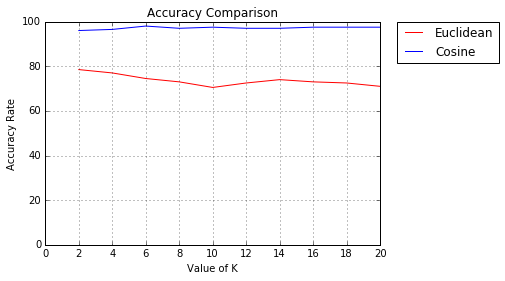

In [7]:
plt.plot(df_complete['Euclidean'], color="red")
plt.plot(df_complete['Cosine'], color="blue")
plt.xlabel('Value of K')
plt.ylabel('Accuracy Rate')
plt.title('Accuracy Comparison')
plt.ylim([0,100])
plt.xlim([0,20])
plt.xticks(range(0,22,2))
plt.legend(['Euclidean', 'Cosine'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

## Part D - TDIDF

In [8]:
TD_train = df_train.T
TD_test = df_test.T
DT_train = df_train
DT_test = df_test

In [9]:
numTerms_train  = DT_train.shape[1]
NDocs_train = DT_train.shape[0]

numTerms_test  = DT_test.shape[1]
NDocs_test = DT_test.shape[0]

termFreqs_train = TD_train.sum(axis = 1)
termFreqs_test = TD_test.sum(axis = 1)

In [10]:
dictTF_train = {}
for i in range(len(termFreqs_train)):
    dictTF_train[i] = termFreqs_train[i]
sortedTF_train = sorted(dictTF_train.values(), reverse = True)

dictTF_test = {}
for i in range(len(termFreqs_test)):
    dictTF_test[i] = termFreqs_test[i]
sortedTF_test = sorted(dictTF_test.values(), reverse = True)

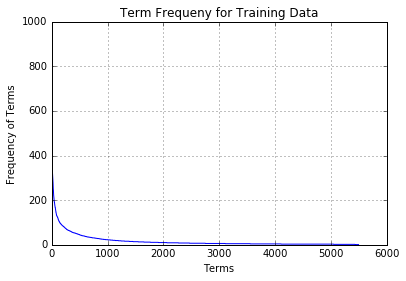

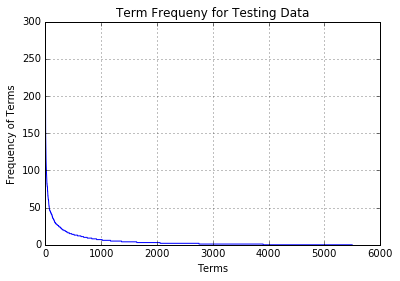

In [11]:
plt.plot(sortedTF_train)
plt.grid()
plt.xlabel('Terms')
plt.ylabel('Frequency of Terms')
plt.title('Term Frequeny for Training Data')
plt.show()

plt.plot(sortedTF_test)
plt.grid()
plt.xlabel('Terms')
plt.ylabel('Frequency of Terms')
plt.title('Term Frequeny for Testing Data')
plt.show()

In [12]:
DF_train =np.array([(TD_train!=0).sum(1)]).T
DF_test =np.array([(TD_test!=0).sum(1)]).T

NMatrix_train = np.ones(np.shape(TD_train), dtype = float) * NDocs_train
np.set_printoptions(precision=2, suppress=True,linewidth=120)

NMatrix_test = np.ones(np.shape(TD_test), dtype = float) * NDocs_test
np.set_printoptions(precision=2, suppress=True,linewidth=120)

In [13]:
IDF_train = np.log2(np.divide(NMatrix_train,DF_train))
IDF_test = np.log2(np.divide(NMatrix_test,DF_test))

TDIDF_train = (TD_train *IDF_train).T
TDIDF_test = (TD_test * IDF_test).T
TDIDF_test = np.nan_to_num(TDIDF_test)

### Part d (Contd) - Comparison of Results 

In [15]:
metrics_list = ['Euclidean', 'Cosine']
K_list = [2,4,6,8,10,12,14,16,18,20]

TD_Euc_dict = {}
TD_Cos_dict = {}
for metric in metrics_list:
    for K in K_list:
        acc = class_accuracy(TDIDF_test, TDIDF_train, train_lab, K, metric, test_lab)
        #sample_dict[metric,K] = sample_dict.get(metric,acc)
        if metric == 'Euclidean':
            TD_Euc_dict[K] = TD_Euc_dict.get(K, acc)
        else:
            TD_Cos_dict[K] = TD_Cos_dict.get(K, acc)

from collections import defaultdict
compl_dict = defaultdict(list)

for d in (Euc_dict, Cos_dict, TD_Euc_dict, TD_Cos_dict): # you can list as many input dicts as you want here
    for key, value in d.iteritems():
        compl_dict[key].append(value)
        
df_both = pd.DataFrame(compl_dict.values(), index = compl_dict.keys(), columns = ['Euclidean', 'Cosine', 
                                                                                  'Euclidean with TDIDF', 
                                                                                      'Cosine with TDIDF'])
df_both            

,Euclidean,Cosine,Euclidean with TDIDF,Cosine with TDIDF
2,78.5,96.0,73.0,96.0
4,77.0,96.5,77.5,97.5
6,74.5,98.0,69.5,97.5
8,73.0,97.0,65.0,99.0
10,70.5,97.5,61.0,99.5
12,72.5,97.0,63.0,99.5
14,74.0,97.0,61.0,99.5
16,73.0,97.5,58.0,99.5
18,72.5,97.5,58.0,99.0
20,71.0,97.5,58.5,99.0


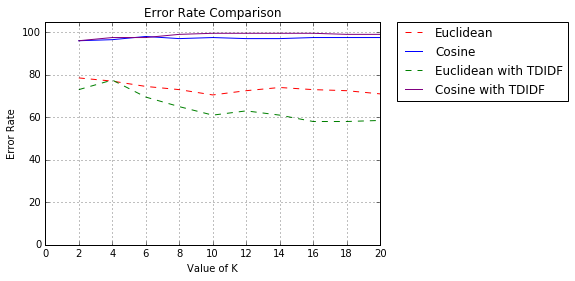

In [16]:
plt.plot(df_both['Euclidean'], color="red", ls = '--')
plt.plot(df_both['Cosine'], color="blue")
plt.plot(df_both['Euclidean with TDIDF'], color="green", ls = '--')
plt.plot(df_both['Cosine with TDIDF'], color="purple")

plt.xlabel('Value of K')
plt.ylabel('Error Rate')
plt.title('Error Rate Comparison')
plt.ylim([0,105])
plt.xlim([0,20])
plt.xticks(range(0,22,2))
plt.legend(['Euclidean', 'Cosine', 'Euclidean with TDIDF', 'Cosine with TDIDF'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

##  Part e - Rocchio Classifier


In [18]:
def roc_classifier(inX, train_data,train_label):
     
    data_label = np.column_stack((train_data,train_label.T))
    
    # Prototype for each of the two classes
    prototype_one = np.array(np.zeros(train_data.shape[1]+1))
    prototype_zero = np.array(np.zeros(train_data.shape[1]+1))    
    
    for i in data_label:
        if i[-1] == 1:
            prototype_one += i
        else:
            prototype_zero += i
            
    # Computing the cosine similarity 
    
    #Computing Distance based on Cosine Similarity for the Class 0 protoype    
    cos_zero = (np.dot(prototype_zero[:len(prototype_zero)-1],inX))/(np.linalg.norm(prototype_zero) * np.linalg.norm(inX))
    distance_zero = 1 - cos_zero
    #Computing Distance based on Cosine Similarity for the Class 1 protoype
    cos_one = (np.dot(prototype_one[:len(prototype_one)-1],inX))/(np.linalg.norm(prototype_one) * np.linalg.norm(inX))
    distance_one = 1 - cos_one
    if distance_zero < distance_one:
        return 0
    else:
        return 1

In [19]:
def roc_accuracy(test_data, train_data, train_label, test_label):
    Accuracy = 0.0
    len_test = len(test_label)
    m = [] 
    for i in range(len_test):
        classifierResult = roc_classifier(test_data[i,:], train_data, train_label)
        if (classifierResult == test_label[i]): Accuracy += 1.0
    Acc_rate =((Accuracy/float(len_test))*100)
    return Acc_rate

In [20]:
print 'The Accuracy Rate for Rocchio Classifier is' , roc_accuracy(TDIDF_test, TDIDF_train, train_lab, test_lab)

The Accuracy Rate for Rocchio Classifier is 98.0


## Conclusion

- Running the KNN with raw data, we can see that there is a huge difference between the accuracy computed by different Distance measures of Cosine Similarity and Euclidean distance had a significant difference,The Cosine Similarity increased with the increase in the number of neighbors & the accuracy of Euclidean distance decreased with the increase in the number of neighbors.

- Using the TDxIDF, the Second KNN classifier also had similar differences as the first one. The accuracy using Cosine Similarity Distance Measure was really high and at times reached 99.5% as well, whereas the accuracy using Euclidean distance decreased.

- Using the Rocchio Method for KNN classification gave the Accuracy of 98% , which is significantly high and uses less amount of resources.